# Demo Program

This is the demo program that I've made to show what I did in this project, just run and wait for the pictures be inpainted.

In [4]:
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
import numpy as np
from math import inf
from matplotlib import colors
import imageio as imgio
import matplotlib.pyplot as plt

# function to normalize a matrix
def normalize(im, rmin = 0, rmax = 255):
    im_n = im.copy().astype(np.float)
    if (len(im.shape) == 2) or ((len(im.shape) > 2) and im.shape[2] == 1):
        im_float = im.astype(float)
        # gets the max and min values in the image
        vmax = im_float.max()
        vmin = im_float.min()
        # makes its values be between rmin and rmax
        if vmin != vmax:
            im_n = np.multiply((im_float - vmin), (rmax - rmin) / (vmax - vmin)) + rmin
        elif vmax != 0:
            im_n = im_float * (rmax - rmin) / vmax + rmin

    else:
        for i in range(im.shape[2]):
            im_channel = im[:,:,i].astype(np.float)
            # gets the max and min values in the image
            vmax = np.max(im_channel)
            vmin = np.min(im_channel)
            # makes its values be between rmin and rmax
            if vmin != vmax:
                im_n[:,:,i] = np.multiply((im_channel - vmin), (rmax - rmin) / (vmax - vmin)) + rmin
            elif vmax != 0:
                im_n[:,:,i] = im_channel * (rmax - rmin) / vmax + rmin

    if(rmin >= 0 and rmax <= 255):
        return im_n.astype(np.uint8)

    return im_n

def histogram(A, no_levels=255, normalized=True):
    no_levels = int(no_levels)

    # creates an empty histogram with size proportional to the number of graylevels
    hist = np.zeros(no_levels, dtype=np.uint32)

    if normalized:
        A_n = A
    else:
        A_n = normalize(A, rmin=0, rmax=no_levels).astype(np.uint32)

    # computes for all levels in the range
    for i in range(no_levels):
        # the np.where() function returns the indices for all coordinates 
        # in some array matching the condition. In this case, all pixels
        # that have value 'i'
        pixels_value_i = np.where(A_n == i)

        #print(pixels_value_i)  # uncomment to print array of coordinates

        # by counting how many coordinates the np.where function returned, 
        # we can assign it at the respective histogram bin
        # this is done by getting the size of the vector of coordinates
        hist[i] = pixels_value_i[0].shape[0]

    return (hist)

def lawsHist(laws_em, colorLevels=None, imprime=False):
    hist = []
    if(colorLevels):
        for i in range(len(laws_em)):
            hist.append(histogram(laws_em[i], colorLevels[i]))
            if imprime:
                plt.bar(range(int(colorLevels[i])), hist[i], align='center')
                plt.yscale('log')
                plt.show()
        hist = np.array(hist)
        return hist

    colorLevels = []
    for i in range(len(laws_em)):
        colorLevels.append(laws_em[i].max() - laws_em[i].min() + 1)
        hist.append(histogram(laws_em[i], colorLevels[i]))
        if imprime:
            plt.bar(range(int(colorLevels[i])), hist[i], align='center')
            plt.yscale('log')
            plt.show()

    return (np.array(hist), np.sum(np.array(colorLevels, dtype=np.uint32)));

def lawsWindowedHist(laws_em, colorLevels, imprime=False):
    hist = np.array(1)
    for i in range(len(laws_em)):
        hist_i = np.zeros(colorLevels[i])
        hist_i[laws_em[i].astype(np.uint32)] += 1
        if imprime:
            plt.bar(range(int(colorLevels[i])), hist[i], align='center')
            plt.yscale('log')
            plt.show()
        hist = np.append(hist, hist_i)
    return hist

# binarize an image with LBP technique
def rebinarize(fimg, pad):
    im = fimg[pad:-pad, pad:-pad]
    f8 = np.greater(fimg[:fimg.shape[0] - 2, :fimg.shape[1] - 2], im).astype(np.uint8)
    f7 = np.greater(fimg[:fimg.shape[0] - 2, 1:fimg.shape[1] - 1], im).astype(np.uint8)
    f6 = np.greater(fimg[:fimg.shape[0] - 2, 2:], im).astype(np.uint8)
    f5 = np.greater(fimg[1:fimg.shape[0] - 1, 2:], im).astype(np.uint8)
    f4 = np.greater(fimg[2:, 2:], im).astype(np.uint8)
    f3 = np.greater(fimg[2:, 1:fimg.shape[1] - 1], im).astype(np.uint8)
    f2 = np.greater(fimg[2:, :fimg.shape[1] - 2], im).astype(np.uint8)
    f1 = np.greater(fimg[1:fimg.shape[0] - 1, :fimg.shape[1] - 2], im).astype(np.uint8)
    changes = np.zeros(im.shape)
    changes[np.where(f8 != f7)] += 1
    changes[np.where(f7 != f6)] += 1
    changes[np.where(f6 != f5)] += 1
    changes[np.where(f5 != f4)] += 1
    changes[np.where(f4 != f3)] += 1
    changes[np.where(f3 != f2)] += 1
    changes[np.where(f2 != f1)] += 1
    nonUniformIndexes = np.where(changes > 2)
    f7 = np.left_shift(f7, 1)
    f6 = np.left_shift(f6, 2)
    f5 = np.left_shift(f5, 3)
    f4 = np.left_shift(f4, 4)
    f3 = np.left_shift(f3, 5)
    f2 = np.left_shift(f2, 6)
    f1 = np.left_shift(f1, 7)
    # uncomment lines bellow to see the result of each bit from the final image
    #plt.figure(dpi=200)
    #plt.subplot(421)
    #plt.imshow(f1, cmap = 'gray'); plt.axis('off'); plt.title("bit 7")
    #plt.subplot(422)
    #plt.imshow(f2, cmap = 'gray'); plt.axis('off'); plt.title("bit 6")
    #plt.subplot(423)
    #plt.imshow(f3, cmap = 'gray'); plt.axis('off'); plt.title("bit 5")
    #plt.subplot(424)
    #plt.imshow(f4, cmap = 'gray'); plt.axis('off'); plt.title("bit 4")
    #plt.subplot(425)
    #plt.imshow(f5, cmap = 'gray'); plt.axis('off'); plt.title("bit 3")
    #plt.subplot(426)
    #plt.imshow(f6, cmap = 'gray'); plt.axis('off'); plt.title("bit 2")
    #plt.subplot(427)
    #plt.imshow(f7, cmap = 'gray'); plt.axis('off'); plt.title("bit 1")
    #plt.subplot(428)
    #plt.imshow(f8, cmap = 'gray'); plt.axis('off'); plt.title("bit 0")
    #plt.show()
    rimg = np.sum([f1, f2, f3, f4, f5, f6, f7, f8], axis = 0).astype(np.uint8)
    
    # assigns the same label to all  no-uniform values
    rimg[nonUniformIndexes] = 82

    return rimg

# binarize an image with LBP technique
def binarize(im):
    fimg = np.zeros((im.shape[0] + 2, im.shape[1] + 2)).astype(np.uint8)
    fimg[1 : 1 + im.shape[0], 1 : 1 + im.shape[1]] = im
    f8 = np.greater(fimg[:fimg.shape[0] - 2, :fimg.shape[1] - 2], im).astype(np.uint8)
    f7 = np.greater(fimg[:fimg.shape[0] - 2, 1:fimg.shape[1] - 1], im).astype(np.uint8)
    f6 = np.greater(fimg[:fimg.shape[0] - 2, 2:], im).astype(np.uint8)
    f5 = np.greater(fimg[1:fimg.shape[0] - 1, 2:], im).astype(np.uint8)
    f4 = np.greater(fimg[2:, 2:], im).astype(np.uint8)
    f3 = np.greater(fimg[2:, 1:fimg.shape[1] - 1], im).astype(np.uint8)
    f2 = np.greater(fimg[2:, :fimg.shape[1] - 2], im).astype(np.uint8)
    f1 = np.greater(fimg[1:fimg.shape[0] - 1, :fimg.shape[1] - 2], im).astype(np.uint8)
    changes = np.zeros(im.shape)
    changes[np.where(f8 != f7)] += 1
    changes[np.where(f7 != f6)] += 1
    changes[np.where(f6 != f5)] += 1
    changes[np.where(f5 != f4)] += 1
    changes[np.where(f4 != f3)] += 1
    changes[np.where(f3 != f2)] += 1
    changes[np.where(f2 != f1)] += 1
    nonUniformIndexes = np.where(changes > 2)
    f7 = np.left_shift(f7, 1)
    f6 = np.left_shift(f6, 2)
    f5 = np.left_shift(f5, 3)
    f4 = np.left_shift(f4, 4)
    f3 = np.left_shift(f3, 5)
    f2 = np.left_shift(f2, 6)
    f1 = np.left_shift(f1, 7)
    # uncomment lines bellow to see the result of each bit from the final image
    #plt.figure(dpi=200)
    #plt.subplot(421)
    #plt.imshow(f1, cmap = 'gray'); plt.axis('off'); plt.title("bit 7")
    #plt.subplot(422)
    #plt.imshow(f2, cmap = 'gray'); plt.axis('off'); plt.title("bit 6")
    #plt.subplot(423)
    #plt.imshow(f3, cmap = 'gray'); plt.axis('off'); plt.title("bit 5")
    #plt.subplot(424)
    #plt.imshow(f4, cmap = 'gray'); plt.axis('off'); plt.title("bit 4")
    #plt.subplot(425)
    #plt.imshow(f5, cmap = 'gray'); plt.axis('off'); plt.title("bit 3")
    #plt.subplot(426)
    #plt.imshow(f6, cmap = 'gray'); plt.axis('off'); plt.title("bit 2")
    #plt.subplot(427)
    #plt.imshow(f7, cmap = 'gray'); plt.axis('off'); plt.title("bit 1")
    #plt.subplot(428)
    #plt.imshow(f8, cmap = 'gray'); plt.axis('off'); plt.title("bit 0")
    #plt.show()
    rimg = np.sum([f1, f2, f3, f4, f5, f6, f7, f8], axis = 0).astype(np.uint8)

    # assigns the same label to all  no-uniform values
    rimg[nonUniformIndexes] = 82

    return rimg

# the function used to remove ilumination effects in the given image, used as preprocessing of
# the image in the Laws texture energy
def removeLuminosityEffect(im):
    pimg = zeroPaddify(im, 7)
    rangej = range(7, im.shape[1] + 7)
    fimg = im.copy().astype(float)
    for i in range(7, im.shape[0] + 7):
        for j in rangej:
            li_i = i - 7
            li_j = j - 7
            mean = np.mean(pimg[li_i:i+7, li_j:j+7])
            fimg[li_i][li_j] -= mean
    return fimg

def removeLuminosityEffect2(im):
    return colors.rgb_to_luv(im)[:,:,2]

# function to pad an image with zeros
# returns the given image padded with zeros to match the dimensions given in dimf
# exemples:
# 3x3 padded to be a 8x8         3x3 padded to be a 9x9
#   |0 0 0 0 0 0 0 0|             |0 0 0 0 0 0 0 0 0|
#   |0 0 0 0 0 0 0 0|             |0 0 0 0 0 0 0 0 0|
#   |0 0 0 0 0 0 0 0|             |0 0 0 0 0 0 0 0 0|
#   |0 0 0 x x x 0 0|             |0 0 0 x x x 0 0 0|
#   |0 0 0 x x x 0 0|             |0 0 0 x x x 0 0 0|
#   |0 0 0 x x x 0 0|             |0 0 0 x x x 0 0 0|
#   |0 0 0 0 0 0 0 0|             |0 0 0 0 0 0 0 0 0|
#   |0 0 0 0 0 0 0 0|             |0 0 0 0 0 0 0 0 0|
#                                 |0 0 0 0 0 0 0 0 0|
def zeroPaddifyTo(im, dimf):
    # computes the pad in x
    padx = dimf[0] // 2 - im.shape[0] // 2
    # computes the pad in y
    pady = dimf[1] // 2 - im.shape[1] // 2
    # alocates the new padded image with zeros
    newim = np.zeros(dimf, dtype=im.dtype)

    # copies the original image on the center of the new one
    newim[padx : padx + im.shape[0], pady : pady + im.shape[1]] = im

    return newim

# function that paddifies a matrix by 'pad' number of zeros in both axis
def zeroPaddify(im, pad):
    newim = np.zeros((im.shape[0] + 2 * pad, im.shape[1] + 2 * pad), dtype=im.dtype)
    newim[pad : pad + im.shape[0], pad : pad + im.shape[1]] = im
    return newim

def zeroPaddify4(im, padL, padR, padT, padB):
    newim = np.zeros((im.shape[0] + padL + padR, im.shape[1] + padT + padB), dtype=im.dtype)
    newim[padL : padL + im.shape[0], padT : padT + im.shape[1]] = im
    return newim

# function that constructs a symmetric matrix to get a
# padded matrix symetric in its limits
# for example a matrix of weights 5x5 processing a matrix
# also 5x5 would need a padded matrix like the following
# to process all pixels correctly
#                                         A       |       B        |      C
#                                           7  2  | 6  7  8  9  10 | 4  9
#                                           6  1  | 1  2  3  4  5  | 5  10
#                                        ------------------------------------
#              1  2  3  4  5                2  1  | 1  2  3  4  5  | 5  4
#              6  7  8  9  10               7  6  | 6  7  8  9  10 | 10 9
# original --> 11 12 13 14 15  padded --> H 12 11 | 11 12 13 14 15 | 15 14 D
#  image       16 17 18 19 20    one        17 16 | 16 17 18 19 20 | 20 19
#              21 22 23 24 25               22 21 | 21 22 23 24 25 | 25 24
#                                        ------------------------------------
#                                           16 21 | 21 22 23 24 25 | 25 20
#                                           17 22 | 16 17 18 19 20 | 24 19
#                                         G       |       F        |       E
def symPaddify(im, pad):
    newim = np.zeros((im.shape[0] + 2 * pad, im.shape[1] + 2 * pad))

    # creates the center of the padded image
    newim[pad : pad + im.shape[0], pad : pad + im.shape[1]] = im

    # creates the A region of the padded image
    newim[0:pad, 0:pad] = im[pad-1::-1, pad-1::-1]

    # creates the B region of the padded image
    newim[0:pad, pad:newim.shape[1]-pad] = im[pad-1::-1, :]

    # creates the C region of the padded image
    newim[0:pad, -pad:] = im[pad-1::-1, -1:-pad-1:-1]

    # creates the D region of the padded image
    newim[pad:newim.shape[0]-pad, -pad:] = im[:, -1:-pad-1:-1]

    # creates the E region of the padded image
    newim[-pad:, -pad:] = im[-1:-pad-1:-1, -1:-pad-1:-1]

    # creates the F region of the padded image
    newim[-pad:, pad:newim.shape[1]-pad] = im[-1:-pad-1:-1, :]

    # creates the G region of the padded image
    newim[-pad:, 0:pad] = im[-1:-pad-1:-1, pad-1::-1]

    # creates the H region of the padded image
    newim[pad:newim.shape[0]-pad, 0:pad] = im[:, pad-1::-1]

    return newim

def filtering2D(im, weights):
    n = len(weights[0])
    wcenter = n // 2 # the center of the weights matrix, assumes that it is a square matrix

    sym = symPaddify(im, wcenter)

    # filters the image
    fimg = np.zeros(im.shape)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            # gets a submatrix of the image centered at [i, j]
            submat = sym[i : n + i : 1, j : n + j : 1]
            # gets the sum of the dot product of the rows of the submatrix and the rows of the weights matrix
            for k in range(n):
                fimg[i][j] += np.abs(np.dot(submat[k], weights[k]))

    return fimg

def filtering2DFFT(im, weights):
    fftim = ifftshift(fft2(im))
    fftweights = ifftshift(fft2(zeroPaddifyTo(weights, fftim.shape)))
    fftfiltered = np.multiply(fftim, fftweights)
    return np.abs(ifftshift(ifft2(fftfiltered))).astype(float)

def rgb2gray(im):
    if (len(im.shape) == 3) and (im.shape[2] > 1):
        return np.dot(im[:,:,:3].astype(float), [0.2989, 0.5870, 0.1140])
    return im

# the function to compute the 9 Laws texture energy maps
def getLawsEnergyMaps(im):
    # here are defined the 16 matrices used on the cross correlation
    # to get the 16 maps
    L5E5 = np.array([[ -1.0,  -2.0,   0.0,   2.0,   1.0],
            [ -4.0,  -8.0,   0.0,   8.0,   4.0],
            [ -6.0, -12.0,   0.0,  12.0,   6.0],
            [ -4.0,  -8.0,   0.0,   8.0,   4.0],
            [ -1.0,  -2.0,   0.0,   2.0,   1.0]])
    E5L5 = np.array([[ -1.0,  -4.0,  -6.0,  -4.0,  -1.0],
            [ -2.0,  -8.0, -12.0,  -8.0,  -2.0],
            [  0.0,   0.0,   0.0,   0.0,   0.0],
            [  2.0,   8.0,  12.0,   8.0,   2.0],
            [  1.0,   4.0,   6.0,   4.0,   1.0]])
    L5R5 = np.array([[  1.0,  -4.0,   6.0,  -4.0,   1.0],
            [  4.0, -16.0,  24.0, -16.0,   4.0],
            [  6.0, -24.0,  36.0, -24.0,   6.0],
            [  4.0, -16.0,  24.0, -16.0,   4.0],
            [  1.0,  -4.0,   6.0,  -4.0,   1.0]])
    R5L5 = np.array([[  1.0,   4.0,   6.0,   4.0,   1.0],
            [ -4.0, -16.0, -24.0, -16.0,  -4.0],
            [  6.0,  24.0,  36.0,  24.0,   6.0],
            [ -4.0, -16.0, -24.0, -16.0,  -4.0],
            [  1.0,   4.0,   6.0,   4.0,   1.0]])
    E5S5 = np.array([[ 1.0, -0.0, -2.0, -0.0,  1.0],
            [ 2.0, -0.0, -4.0, -0.0,  2.0],
            [-0.0,  0.0,  0.0,  0.0, -0.0],
            [-2.0,  0.0,  4.0,  0.0, -2.0],
            [-1.0,  0.0,  2.0,  0.0, -1.0]])
    S5E5 = np.array([[ 1.0,  2.0, -0.0, -2.0, -1.0],
            [-0.0, -0.0,  0.0,  0.0,  0.0],
            [-2.0, -4.0,  0.0,  4.0,  2.0],
            [-0.0, -0.0,  0.0,  0.0,  0.0],
            [ 1.0,  2.0, -0.0, -2.0, -1.0]])
    S5S5 = np.array([[ 1.0, -0.0, -2.0, -0.0,  1.0],
            [-0.0,  0.0,  0.0,  0.0, -0.0],
            [-2.0,  0.0,  4.0,  0.0, -2.0],
            [-0.0,  0.0,  0.0,  0.0, -0.0],
            [ 1.0, -0.0, -2.0, -0.0,  1.0]])
    R5R5 = np.array([[  1.0,  -4.0,   6.0,  -4.0,   1.0],
            [ -4.0,  16.0, -24.0,  16.0,  -4.0],
            [  6.0, -24.0,  36.0, -24.0,   6.0],
            [ -4.0,  16.0, -24.0,  16.0,  -4.0],
            [  1.0,  -4.0,   6.0,  -4.0,   1.0]])
    L5S5 = np.array([[-1.0,  0.0,  2.0,  0.0, -1.0],
            [-4.0,  0.0,  8.0,  0.0, -4.0],
            [-6.0,  0.0, 12.0,  0.0, -6.0],
            [-4.0,  0.0,  8.0,  0.0, -4.0],
            [-1.0,  0.0,  2.0,  0.0, -1.0]])
    S5L5 = np.array([[-1.0, -4.0, -6.0, -4.0, -1.0],
            [ 0.0,  0.0,  0.0,  0.0,  0.0],
            [ 2.0,  8.0, 12.0,  8.0,  2.0],
            [ 0.0,  0.0,  0.0,  0.0,  0.0],
            [-1.0, -4.0, -6.0, -4.0, -1.0]])
    E5E5 = np.array([[ 1.0,  2.0, -0.0, -2.0, -1.0],
            [ 2.0,  4.0, -0.0, -4.0, -2.0],
            [-0.0, -0.0,  0.0,  0.0,  0.0],
            [-2.0, -4.0,  0.0,  4.0,  2.0],
            [-1.0, -2.0,  0.0,  2.0,  1.0]])
    E5R5 = np.array([[ -1.0,   4.0,  -6.0,   4.0,  -1.0],
            [ -2.0,   8.0, -12.0,   8.0,  -2.0],
            [  0.0,  -0.0,   0.0,  -0.0,   0.0],
            [  2.0,  -8.0,  12.0,  -8.0,   2.0],
            [  1.0,  -4.0,   6.0,  -4.0,   1.0]])
    R5E5 = np.array([[ -1.0,  -2.0,   0.0,   2.0,   1.0],
            [  4.0,   8.0,  -0.0,  -8.0,  -4.0],
            [ -6.0, -12.0,   0.0,  12.0,   6.0],
            [  4.0,   8.0,  -0.0,  -8.0,  -4.0],
            [ -1.0,  -2.0,   0.0,   2.0,   1.0]])
    S5R5 = np.array([[-1.0,  4.0, -6.0,  4.0, -1.0],
            [ 0.0, -0.0,  0.0, -0.0,  0.0],
            [ 2.0, -8.0, 12.0, -8.0,  2.0],
            [ 0.0, -0.0,  0.0, -0.0,  0.0],
            [-1.0,  4.0, -6.0,  4.0, -1.0]])
    R5S5 = np.array([[-1.0,  0.0,  2.0,  0.0, -1.0],
            [ 4.0, -0.0, -8.0, -0.0,  4.0],
            [-6.0,  0.0, 12.0,  0.0, -6.0],
            [ 4.0, -0.0, -8.0, -0.0,  4.0],
            [-1.0,  0.0,  2.0,  0.0, -1.0]])
    # converts the image into gray scale
    im_gray = rgb2gray(im)
    # removes the luminosity effects of the image
    im_sem_luz = removeLuminosityEffect(im_gray)
    # computes the 16 energy maps
    im_L5E5 = filtering2DFFT(im_sem_luz, L5E5).astype(float)
    im_E5L5 = filtering2DFFT(im_sem_luz, E5L5).astype(float)
    im_L5R5 = filtering2DFFT(im_sem_luz, L5R5).astype(float)
    im_R5L5 = filtering2DFFT(im_sem_luz, R5L5).astype(float)
    im_E5S5 = filtering2DFFT(im_sem_luz, E5S5).astype(float)
    im_S5E5 = filtering2DFFT(im_sem_luz, S5E5).astype(float)
    im_S5S5 = filtering2DFFT(im_sem_luz, S5S5).astype(float)
    im_R5R5 = filtering2DFFT(im_sem_luz, R5R5).astype(float)
    im_L5S5 = filtering2DFFT(im_sem_luz, L5S5).astype(float)
    im_S5L5 = filtering2DFFT(im_sem_luz, S5L5).astype(float)
    im_E5E5 = filtering2DFFT(im_sem_luz, E5E5).astype(float)
    im_E5R5 = filtering2DFFT(im_sem_luz, E5R5).astype(float)
    im_R5E5 = filtering2DFFT(im_sem_luz, R5E5).astype(float)
    im_S5R5 = filtering2DFFT(im_sem_luz, S5R5).astype(float)
    im_R5S5 = filtering2DFFT(im_sem_luz, R5S5).astype(float)
    # summarizes then in 9 maps by averaging the symetric ones
    im_fs = []
    im_fs.append(((im_L5E5 + im_E5L5) / 2.0))
    im_fs.append(((im_L5R5 + im_R5L5) / 2.0))
    im_fs.append(((im_E5S5 + im_S5E5) / 2.0))
    im_fs.append(im_S5S5)
    im_fs.append(im_R5R5)
    im_fs.append(((im_L5S5 + im_S5L5) / 2.0))
    im_fs.append(im_E5E5)
    im_fs.append(((im_E5R5 + im_R5E5) / 2.0))
    im_fs.append(((im_S5R5 + im_R5S5) / 2.0))

    return (np.array(im_fs), im_sem_luz)

# class that will select the next pixel to inpaint based on
# the position of the pixel.
# the sequence of inpainting will be from left to right, from top to bottom
# 3x3 image example, as the arrows show:
#     ---------->
#    | |0 0 0 0 0|
#    | |0 0 1 0 0|
#    | |0 1 1 1 0|
#    | |1 1 1 1 1|
#    V |0 1 1 1 0|
class seqSelector:
    def __init__(self, im, mask_limiar=10):
        self._pixelsList = np.where(im > mask_limiar)
        self._listIndex = 0
        self._pixelsListLen = len(self._pixelsList[0])
        self._onePixPercent = 1.0 / self._pixelsListLen
        self._percent = 0.0

    def next(self):
        if(self._listIndex < self._pixelsListLen):
            nexPix = (self._pixelsList[0][self._listIndex], self._pixelsList[1][self._listIndex])
            self._listIndex += 1
            self._percent += self._onePixPercent
            return (nexPix, self._percent)
        else:
            return (None, 100.0)

# the function that computes the distance of im1 and im2
# uses the euclidean distance
def compare(im1, im2):
    im1 = np.reshape(im1, (1,-1))
    im2 = np.reshape(im2, (1,-1))
    return np.sqrt(np.divide(np.sum(np.square(np.subtract(im2.astype(float), im1.astype(float)))), im1.shape[0]))

def compareLawsWindowedHistRegions(region1, region2, colorLevels):
    return compare(lawsWindowedHist(region1, colorLevels), lawsWindowedHist(region2, colorLevels))

def compareChiSquare(im1, im2):
   im1 = im1.astype(float)
   im2 = im2.astype(float)
   notZeros = (np.where(im1 != 0, True, False) | np.where(im2 != 0, True, False))
   return np.sum(np.divide(np.square(im1 - im2), (im1 + im2), where=notZeros))

class matcher:
    def __init__(self, im, mask, window_match_size=3, recompute=False, window_tex_size=3, texType="laws", lawsUsedMaps=None, normalizeMaps=True, mask_limiar=10, useColors=True):
        self._windowMatchRange = window_match_size // 2
        self._windowTexRange = window_tex_size // 2
        self._windowTexSize = window_tex_size
        self._recompute = recompute

        inpaintPixels = np.where(mask > mask_limiar)
        validPixels = np.where(mask <= mask_limiar)
        mask[inpaintPixels] = 255

        # removes the pixels that have windows over pixels to inpaintPixels
        for i in range(inpaintPixels[0].shape[0]):
            validIndexes = np.where((np.abs(validPixels[0] - inpaintPixels[0][i]) > self._windowMatchRange) | ((np.abs(validPixels[1] - inpaintPixels[1][i])) > self._windowMatchRange))
            validPixels = (validPixels[0][validIndexes], validPixels[1][validIndexes])

        self._matchingPixels = validPixels

        # uncomment lines below to see the pixels that will be used for the inpaint
        #pix=np.zeros(mask.shape)
        #pix[validPixels] = 2
        #pix[inpaintPixels] = 1
        #plt.imshow(pix, cmap='gray')
        #plt.show()

        if (texType == "lawsHist") or (texType == "laws"):
            lawsEM, self._im = getLawsEnergyMaps(im)
            # checks if there is a restriction to which laws maps use
            if lawsUsedMaps:
                lawsEM = lawsEM[lawsUsedMaps, :]
            lawsEM_min = np.min(lawsEM)
            lawsEM_max = np.max(lawsEM)

            # adds the channels of the original image on the list of maps
            # tried to make colors improve the result
            if useColors:
                if len(im.shape) > 2:
                    if im.shape[2] > 3:
                        irange = range(3)
                    else:
                        irange = range(im.shape[2])
                    for i in irange:
                        lawsEM = np.append(lawsEM, [im[:,:,i]], axis=0)
                    self._im_depth = i + 1
                else:
                    lawsEM = np.append(lawsEM, [im], axis=0)
                    self._im_depth = 1
            else: self._depth = 0

            if texType == "lawsHist":
                self._colorLevels = []
                for i in range(len(lawsEM)):
                    self._colorLevels.append(int(lawsEM[i].max() - lawsEM[i].min()))
                    lawsEM[i] = normalize(lawsEM[i], rmin=0, rmax=self._colorLevels[i] - 1)
                self._compare = lambda reg1, reg2 : compareLawsWindowedHistRegions(reg1, reg2, self._colorLevels)
            else:
                self._compare = compare
                if normalizeMaps:
                    for i in range(len(lawsEM)):
                        lawsEM[i] = normalize(lawsEM[i], rmin=0, rmax=np.abs(lawsEM_min)+np.abs(lawsEM_max))

            self._recomputeTexFunc = lambda im : getLawsEnergyMaps(im)[0]
            self._tex = np.array(lawsEM)
        ###### end of the Laws constructor particularities ######
        elif (texType == "lbp") or (texType == "lbpHist"):
            self._im = rgb2gray(im)
            lbpIm = binarize(self._im)
            # adds the channels of the original image on the list of maps
            # tried to make colors improve on the result
            if useColors:
                imgs = [lbpIm]
                if len(im.shape) > 2:
                    if im.shape[2] > 3:
                        irange = range(3)
                    else:
                        irange = range(im.shape[2])
                    for i in irange:
                        imgs.append(im[:,:,i])
                    self._im_depth = i + 1
                else:
                    imgs.append(im)
                    self._im_depth = 1
                self._tex = np.array(imgs)
            else:
                self._tex = np.array([lbpIm])
                self._depth = 0
            if texType == "lbpHist":
                self._colorLevels = []
                for i in range(len(self._tex)):
                    self._colorLevels.append(int(self._tex[i].max() - self._tex[i].min()))
                    self._tex[i] = normalize(self._tex[i], rmin=0, rmax=self._colorLevels[i] - 1)
                self._compare = lambda reg1, reg2 : compareLawsWindowedHistRegions(reg1, reg2, self._colorLevels)#compareChiSquare
            else:
                self._compare = compare
            self._recomputeTexFunc = lambda im : rebinarize(im, self._windowTexRange)
        ###### end of the LBP constructor particularities ######

        self._maxX = im.shape[1]
        self._maxY = im.shape[0]

        # uncomment lines below to see the images used as metrics for the inpaint
        #for i in range(len(self._tex)):
        #    plt.imshow(self._tex[i], cmap='gray')
        #    plt.show()

    def _getBoundingLimits(self, pixelPosition, windowRange=None):
        if not windowRange:
            windowRange = self._windowMatchRange

        if pixelPosition[0] == windowRange:
            texMinY = 0
            winMinY = 0
        else:
            if (pixelPosition[0] - windowRange) < 0:
                texMinY = pixelPosition[0]
                winMinY = texMinY
            else:
                texMinY = windowRange
                winMinY = windowRange
        if pixelPosition[0] == self._maxY:
            texMaxY = self._maxY
            winMaxY = 1
        else:
            if (pixelPosition[0] + windowRange) > self._maxY:
                texMaxY = pixelPosition[0]
                winMaxY = self._maxY - pixelPosition[0] + 1
            else:
                texMaxY = self._maxY - windowRange
                winMaxY = windowRange + 1
        if pixelPosition[1] == 0:
            texMinX = 0
            winMinX = 0
        else:
            if (pixelPosition[1] - windowRange) < 0:
                texMinX = pixelPosition[1]
                winMinX = texMinX
            else:
                texMinX = windowRange
                winMinX = windowRange
        if pixelPosition[1] == self._maxX:
            texMaxX = self._maxX
            winMaxX = 1
        else:
            if (pixelPosition[1] + windowRange) > self._maxX:
                texMaxX = pixelPosition[1]
                winMaxX = self._maxX - pixelPosition[1]
            else:
                texMaxX = self._maxX - windowRange
                winMaxX = windowRange + 1
        return (texMinX, texMaxX, texMinY, texMaxY, winMinX, winMaxX, winMinY, winMaxY);

    def _recomputeTex(self, pixelPosition):
        wtr2 = self._windowTexRange * 2
        # if the min x is out of bounds
        if 0 > pixelPosition[1] - wtr2:
            leftLim = 0
            leftPad = wtr2 - pixelPosition[1]
        # if the min x is in of bounds
        else:
            leftLim = pixelPosition[1] - wtr2
            leftPad = 0
        # if the max x is out of bounds
        if self._maxX < pixelPosition[1] + wtr2:
            rightLim = self._maxX
            rightPad = wtr2 - (self._maxX - pixelPosition[1])
        # if the max x is in of bounds
        else:
            rightLim = pixelPosition[1] + wtr2
            rightPad = 0
        # if the min y is out of bounds
        if 0 > pixelPosition[0] - wtr2:
            topLim = 0
            topPad = wtr2 - pixelPosition[0]
        # if the min y is in of bounds
        else:
            topLim = pixelPosition[0] - wtr2
            topPad = 0
        # if the max y is out of bounds
        if self._maxY < pixelPosition[0] + wtr2:
            bottomLim = self._maxY
            bottomPad = wtr2 - (self._maxY - pixelPosition[0])
        # if the max y is in of bounds
        else:
            bottomLim = pixelPosition[0] + wtr2
            bottomPad = 0

        imageArea = self._im[topLim:bottomLim, leftLim:rightLim]

        new_im = self._recomputeTexFunc(zeroPaddify4(imageArea, leftLim, rightLim, topLim, bottomLim))
        if len(new_im.shape) == 2:
            self._tex[0, topLim:bottomLim, leftLim:rightLim] = new_im[topPad:imageArea.shape[0]+topPad, leftPad:imageArea.shape[1]+leftPad]
        else:
            self._tex[:-self._im_depth, topLim:bottomLim, leftLim:rightLim] = new_im[:, topPad:imageArea.shape[0]+topPad, leftPad:imageArea.shape[1]+leftPad]

    def matchRegion(self, mask, pixelPosition, error=5):
        texMinX, texMaxX, texMinY, texMaxY, winMinX, winMaxX, winMinY, winMaxY = self._getBoundingLimits(pixelPosition)
        # slices the window on the pixel to inpaint
        pixSliceMinY = pixelPosition[0]-winMinY
        pixSliceMaxY = pixelPosition[0]+winMaxY
        pixSliceMinX = pixelPosition[1]-winMinX
        pixSliceMaxX = pixelPosition[1]+winMaxX
        inpaintTex = self._tex[:, pixSliceMinY:pixSliceMaxY, pixSliceMinX:pixSliceMaxX]
        maskWindow = mask[pixSliceMinY:pixSliceMaxY, pixSliceMinX:pixSliceMaxX]
        validPix = maskWindow <= 0
        # initialises the best match as infinite
        bestMatch = [(0,0), inf]
        # compares only in the area that the window won't overflow the image indexes
        suitablePixels = np.where((self._matchingPixels[0] >= texMinY) & (self._matchingPixels[0] < texMaxY) & (self._matchingPixels[1] >= texMinX) & (self._matchingPixels[1] < texMaxX))
        suitablePixels = (self._matchingPixels[0][suitablePixels], self._matchingPixels[1][suitablePixels])
        # uncomment lines below to see the area beeing used for the match of the sliding window for each inpainted pixel
        #suitablePixelsIm = np.zeros(self._im.shape)
        #suitablePixelsIm[suitablePixels] = 1
        #plt.imshow(suitablePixelsIm, cmap='gray')
        #plt.show()
        for k in range(suitablePixels[0].shape[0]):
            i = suitablePixels[0][k]
            j = suitablePixels[1][k]
            sliceMinY = i-winMinY
            sliceMaxY = i+winMaxY
            sliceMinX = j-winMinX
            sliceMaxX = j+winMaxX
            windowTex = self._tex[:, sliceMinY:sliceMaxY, sliceMinX:sliceMaxX]
            indexes = np.where(validPix)#(mask[sliceMinY:sliceMaxY, sliceMinX:sliceMaxX] == 0) & validPix)
            dist = self._compare(inpaintTex[:, indexes[0], indexes[1]], windowTex[:, indexes[0], indexes[1]])
            if dist <= error:
                self._im[pixelPosition[0], pixelPosition[1]] = self._im[i, j]
                if self._recompute:
                    self._recomputeTex(pixelPosition)
                return (i, j);
            if bestMatch[1] > dist:
                bestMatch = [(i, j), dist]

        self._im[pixelPosition[0], pixelPosition[1]] = self._im[bestMatch[0][0], bestMatch[0][1]]
        if self._recompute:
            self._recomputeTex(pixelPosition)
        return bestMatch[0]

# function to inpaint the image 'im' in the areas indicated by image 'mask'
# uses the selector of pixel to inpaint chosen through the argument 'pix_sel'
def inpaint(im, mask, pix_sel="seq", tex_match="laws", tolerance=5, recompute=False, window_match_size=3, window_tex_size=3, normalizeMaps=True, useColors=True):
    if len(mask.shape) > 2:
        mymask = mask[:,:,0].copy().astype(float)
    else:
        mymask = mask.copy().astype(float)

    # uses the chosen pixel selector
    if pix_sel == "seq":
        pixSel = seqSelector(mymask)

    texMatcher = matcher(im, mymask, window_match_size=window_match_size, recompute=recompute, window_tex_size=window_tex_size, texType=tex_match, lawsUsedMaps=None, normalizeMaps=normalizeMaps, useColors=useColors)
    # gets the colors channels, used when loading png images
    if len(im.shape) > 2:
        if im.shape[2] > 3:
            im = im[:,:,:3]

    rimg = im.copy().astype(float)

    pixel, coverage = pixSel.next()
    count = -50
    while(pixel):
        newPixel = texMatcher.matchRegion(mymask, pixel, error=tolerance)
        rimg[pixel] = im[newPixel]
        mymask[pixel] = count
        mymask[newPixel] = count
        count -= 1
        pixel, coverage = pixSel.next()

    return rimg

#### Laws Energy Maps

First used in this project, I didn't had the time to keep looking in this method, not even if it can be used for texture analisys, but I tought that it would be good because it produces 9 different images, called Laws Energy Maps. So I thought that with 9 images I could compare the pixels in 9 dimensions and that would give good results.

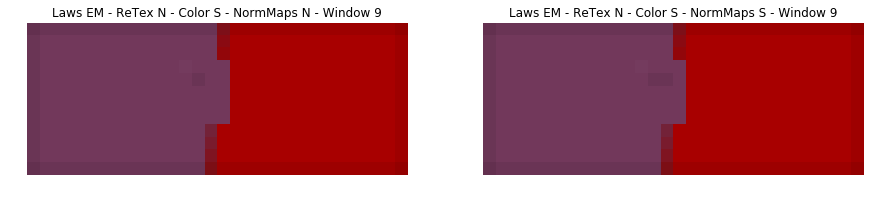

In [11]:
simple_nano = imgio.imread("images/simple-damaged_nano.png").astype(np.uint8)
simple_mask_nano = imgio.imread("images/simple-mask_nano.png").astype(np.uint8)

simple_laws_nano_i1 = inpaint(simple_nano, simple_mask_nano, window_match_size=9, tolerance=0, normalizeMaps=False)
simple_laws_nano_i2 = inpaint(simple_nano, simple_mask_nano, window_match_size=9, tolerance=0, normalizeMaps=True)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(simple_laws_nano_i1.astype(np.uint8))
plt.title("Laws EM - ReTex N - Color S - NormMaps N - Window 9"); plt.axis("off")
plt.subplot(122)
plt.imshow(simple_laws_nano_i2.astype(np.uint8))
plt.title("Laws EM - ReTex N - Color S - NormMaps S - Window 9"); plt.axis("off")
plt.show()

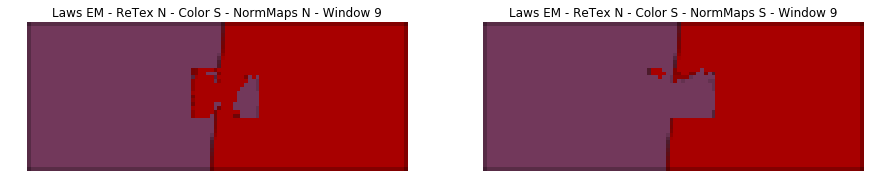

In [12]:
simple_mini = imgio.imread("images/simple-damaged_mini.png").astype(np.uint8)
simple_mask_mini = imgio.imread("images/simple-mask_mini.png").astype(np.uint8)

simple_laws_mini_i1 = inpaint(simple_mini, simple_mask_mini, window_match_size=9, tolerance=0, normalizeMaps=False)
simple_laws_mini_i2 = inpaint(simple_mini, simple_mask_mini, window_match_size=9, tolerance=0, normalizeMaps=True)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(simple_laws_mini_i1.astype(np.uint8))
plt.title("Laws EM - ReTex N - Color S - NormMaps N - Window 9"); plt.axis("off")
plt.subplot(122)
plt.imshow(simple_laws_mini_i2.astype(np.uint8))
plt.title("Laws EM - ReTex N - Color S - NormMaps S - Window 9"); plt.axis("off")
plt.show()

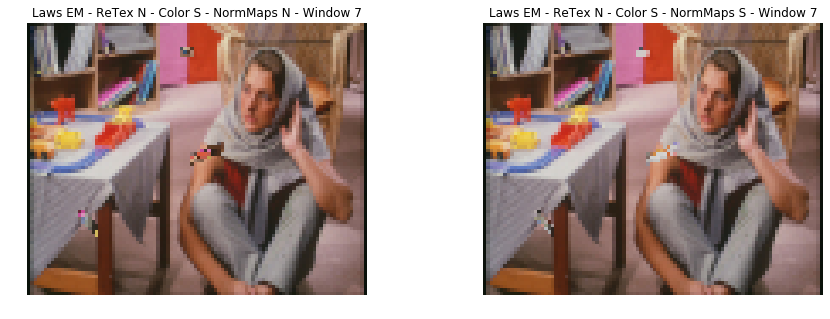

In [16]:
barbara_mini = imgio.imread("images/barbara-damaged_mini.jpg").astype(np.uint8)
barbara_mask_mini = imgio.imread("images/barbara-mask_mini.jpg").astype(np.uint8)

barbara_laws_mini_i1 = inpaint(barbara_mini, barbara_mask_mini, window_match_size=7, tolerance=0, normalizeMaps=False)
barbara_laws_mini_i2 = inpaint(barbara_mini, barbara_mask_mini, window_match_size=7, tolerance=0, normalizeMaps=True)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(barbara_laws_mini_i1.astype(np.uint8))
plt.title("Laws EM - ReTex N - Color S - NormMaps N - Window 7"); plt.axis("off")
plt.subplot(122)
plt.imshow(barbara_laws_mini_i2.astype(np.uint8))
plt.title("Laws EM - ReTex N - Color S - NormMaps S - Window 7"); plt.axis("off")
plt.show()

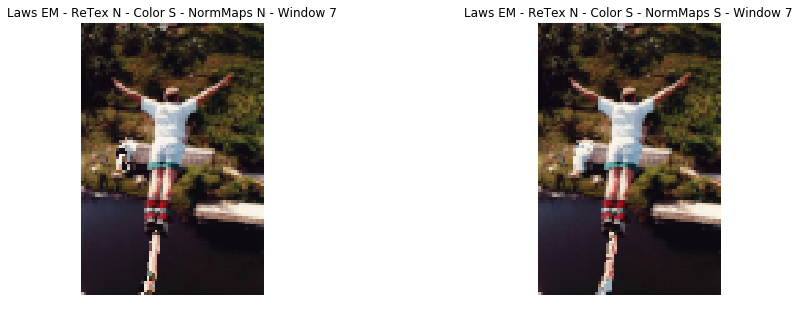

In [17]:
bungee_mini = imgio.imread("images/bungeeJump-damaged_mini.jpg").astype(np.uint8)
bungee_mask_mini = imgio.imread("images/bungeeJump-mask_mini.jpg").astype(np.uint8)

bungee_laws_mini_i1 = inpaint(bungee_mini, bungee_mask_mini, window_match_size=7, tolerance=0, normalizeMaps=False)
bungee_laws_mini_i2 = inpaint(bungee_mini, bungee_mask_mini, window_match_size=7, tolerance=0, normalizeMaps=True)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(bungee_laws_mini_i1.astype(np.uint8))
plt.title("Laws EM - ReTex N - Color S - NormMaps N - Window 7"); plt.axis("off")
plt.subplot(122)
plt.imshow(bungee_laws_mini_i2.astype(np.uint8))
plt.title("Laws EM - ReTex N - Color S - NormMaps S - Window 7"); plt.axis("off")
plt.show()

##### Using the histogram of the Laws EM for comparison

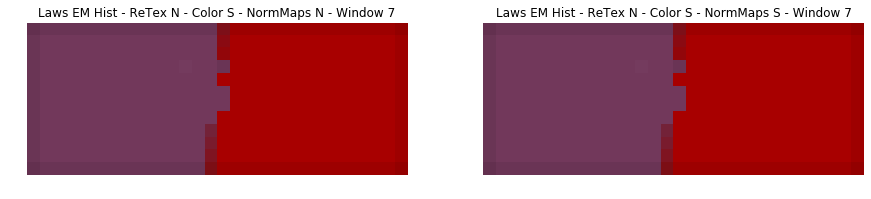

In [20]:
simple_laws_h_nano_i1 = inpaint(simple_nano, simple_mask_nano, tex_match="lawsHist", window_match_size=7, tolerance=0, normalizeMaps=False)
simple_laws_h_nano_i2 = inpaint(simple_nano, simple_mask_nano, tex_match="lawsHist", window_match_size=7, tolerance=0, normalizeMaps=True)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(simple_laws_h_nano_i1.astype(np.uint8))
plt.title("Laws EM Hist - ReTex N - Color S - NormMaps N - Window 7"); plt.axis("off")
plt.subplot(122)
plt.imshow(simple_laws_h_nano_i2.astype(np.uint8))
plt.title("Laws EM Hist - ReTex N - Color S - NormMaps S - Window 7"); plt.axis("off")
plt.show()

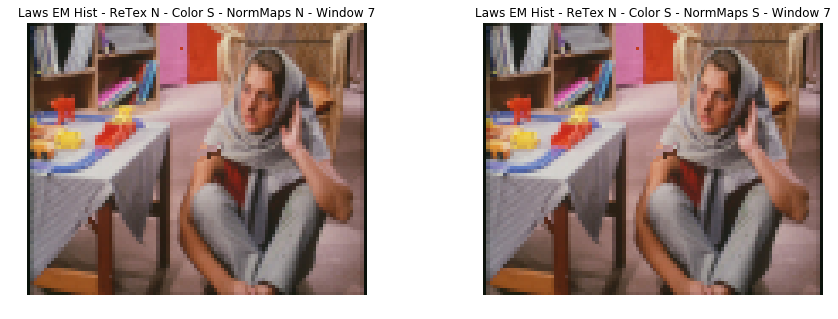

In [21]:
barbara_laws_h_mini_i1 = inpaint(barbara_mini, barbara_mask_mini, tex_match="lawsHist", window_match_size=7, tolerance=0, normalizeMaps=False)
barbara_laws_h_mini_i2 = inpaint(barbara_mini, barbara_mask_mini, tex_match="lawsHist", window_match_size=7, tolerance=0, normalizeMaps=True)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(barbara_laws_h_mini_i1.astype(np.uint8))
plt.title("Laws EM Hist - ReTex N - Color S - NormMaps N - Window 7"); plt.axis("off")
plt.subplot(122)
plt.imshow(barbara_laws_h_mini_i2.astype(np.uint8))
plt.title("Laws EM Hist - ReTex N - Color S - NormMaps S - Window 7"); plt.axis("off")
plt.show()

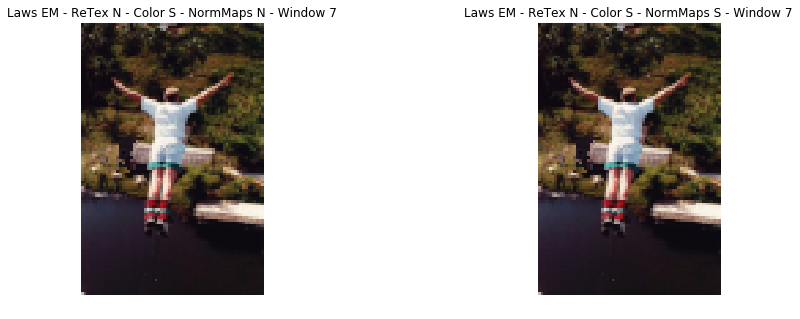

In [22]:
bungee_laws_h_mini_i1 = inpaint(bungee_mini, bungee_mask_mini, tex_match="lawsHist", window_match_size=7, tolerance=0, normalizeMaps=False)
bungee_laws_h_mini_i2 = inpaint(bungee_mini, bungee_mask_mini, tex_match="lawsHist", window_match_size=7, tolerance=0, normalizeMaps=True)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(bungee_laws_h_mini_i1.astype(np.uint8))
plt.title("Laws EM - ReTex N - Color S - NormMaps N - Window 7"); plt.axis("off")
plt.subplot(122)
plt.imshow(bungee_laws_h_mini_i2.astype(np.uint8))
plt.title("Laws EM - ReTex N - Color S - NormMaps S - Window 7"); plt.axis("off")
plt.show()

#### LBP Histograms

Then I decided to use LBP to compare the textures.

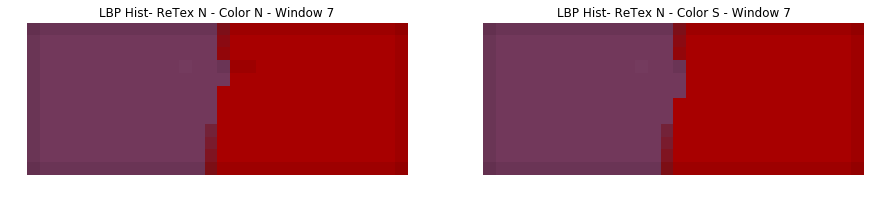

In [26]:
simple_lbp_h_nano_i1 = inpaint(simple_nano, simple_mask_nano, tex_match="lbpHist", window_match_size=7, tolerance=0, useColors=False)
simple_lbp_h_nano_i2 = inpaint(simple_nano, simple_mask_nano, tex_match="lbpHist", window_match_size=7, tolerance=0, useColors=True)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(simple_lbp_h_nano_i1.astype(np.uint8))
plt.title("LBP Hist- ReTex N - Color N - Window 7"); plt.axis("off")
plt.subplot(122)
plt.imshow(simple_lbp_h_nano_i2.astype(np.uint8))
plt.title("LBP Hist- ReTex N - Color S - Window 7"); plt.axis("off")
plt.show()

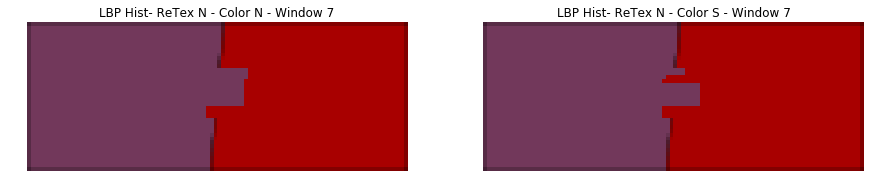

In [27]:
simple_lbp_h_mini_i1 = inpaint(simple_mini, simple_mask_mini, tex_match="lbpHist", window_match_size=7, tolerance=0, useColors=False)
simple_lbp_h_mini_i2 = inpaint(simple_mini, simple_mask_mini, tex_match="lbpHist", window_match_size=7, tolerance=0, useColors=True)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(simple_lbp_h_mini_i1.astype(np.uint8))
plt.title("LBP Hist- ReTex N - Color N - Window 7"); plt.axis("off")
plt.subplot(122)
plt.imshow(simple_lbp_h_mini_i2.astype(np.uint8))
plt.title("LBP Hist- ReTex N - Color S - Window 7"); plt.axis("off")
plt.show()

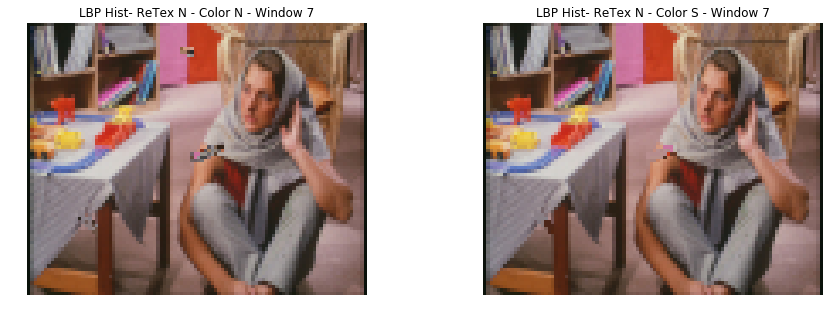

In [28]:
barbara_lbp_h_mini_i1 = inpaint(barbara_mini, barbara_mask_mini, tex_match="lbpHist", window_match_size=7, tolerance=0, useColors=False)
barbara_lbp_h_mini_i2 = inpaint(barbara_mini, barbara_mask_mini, tex_match="lbpHist", window_match_size=7, tolerance=0, useColors=True)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(barbara_lbp_h_mini_i1.astype(np.uint8))
plt.title("LBP Hist- ReTex N - Color N - Window 7"); plt.axis("off")
plt.subplot(122)
plt.imshow(barbara_lbp_h_mini_i2.astype(np.uint8))
plt.title("LBP Hist- ReTex N - Color S - Window 7"); plt.axis("off")
plt.show()

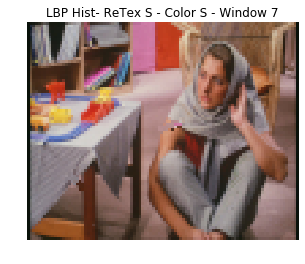

In [31]:
barbara_lbp_h_mini_i3 = inpaint(barbara_mini, barbara_mask_mini, tex_match="lbpHist", recompute=True, window_match_size=7, tolerance=0, useColors=True)
plt.imshow(barbara_lbp_h_mini_i3.astype(np.uint8))
plt.title("LBP Hist- ReTex S - Color S - Window 7"); plt.axis("off")
plt.show()

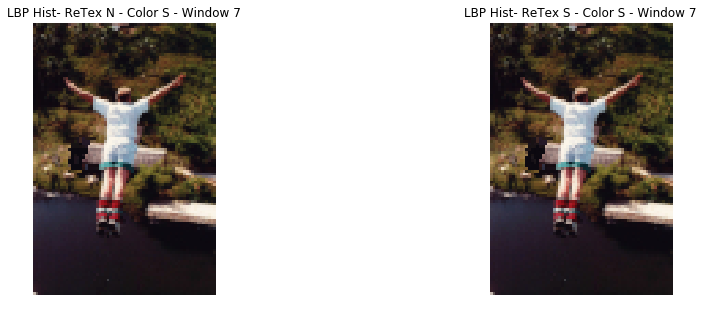

In [32]:
bungee_lbp_h_mini_i1 = inpaint(bungee_mini, bungee_mask_mini, tex_match="lbpHist", recompute=False, window_match_size=7, tolerance=0, useColors=True)
bungee_lbp_h_mini_i2 = inpaint(bungee_mini, bungee_mask_mini, tex_match="lbpHist", recompute=True, window_match_size=7, tolerance=0, useColors=True)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(bungee_lbp_h_mini_i1.astype(np.uint8))
plt.title("LBP Hist- ReTex N - Color S - Window 7"); plt.axis("off")
plt.subplot(122)
plt.imshow(bungee_lbp_h_mini_i2.astype(np.uint8))
plt.title("LBP Hist- ReTex S - Color S - Window 7"); plt.axis("off")
plt.show()

#### Haralick Descriptors

I've tried the Haralick descriptors to see if the results would be better, but the code is buggy and I couldn't make any tests on it, yet.

In [29]:
# function to compute the co-ocurrence matrices of a neighbourhood
def getCoocurrenceMatrices(im, gray_lvs):
   mat = np.zeros((4, gray_lvs, gray_lvs), dtype=float)
   grays = range(gray_lvs)
   #horizontal co-ocurrence
   # removes the last columm of the predecessor image
   im_p_h = im[:, :-1]
   # vertical co-ocurrence
   # removes the last row of the predecessor image
   im_p_v = im[:-1]
   # principal diagonnal co-ocurrence
   # removes last row and columm
   im_p_pd = im_p_h[:-1]
   # second diagonal co-ocurrence
   # removes last row and first columm
   im_p_sd = im[:-1, 1:]
   # computes for each gray level
   for gray in grays:
      # finds the indexes of all precedent pixels that are of this gray level
      indexes_h = np.where(im_p_h == gray)
      indexes_v = np.where(im_p_v == gray)
      indexes_pd = np.where(im_p_pd == gray)
      indexes_sd = np.where(im_p_sd == gray)
      # gets the pixels that are their successors
      succe_h = im[indexes_h[0], indexes_h[1] + 1]
      succe_v = im[indexes_v[0] + 1, indexes_v[1]]
      succe_pd = im[indexes_pd[0] + 1, indexes_pd[1] + 1]
      succe_sd = im[indexes_sd[0] + 1, indexes_sd[1]]
      # computes the co-ocurrences
      for j in range(succe_h.shape[0]):
         mat[0, gray, int(succe_h[j])] += 1
      for j in range(succe_v.shape[0]):
         mat[1, gray, int(succe_v[j])] += 1
      for j in range(succe_pd.shape[0]):
         mat[2, gray, int(succe_pd[j])] += 1
      for j in range(succe_sd.shape[0]):
         mat[3, gray, int(succe_sd[j])] += 1
   for i in range(4):
      mat[i] /= np.sum(mat[i])
   return mat

def getMeansAndStds(coocMats, gray_lvs):
   grays = np.arange(gray_lvs)
   mr = np.zeros(4, dtype=float)
   mc = np.zeros(4, dtype=float)
   stdr = np.zeros(4, dtype=float)
   stdc = np.zeros(4, dtype=float)
   for i in range(4):
      # gets the sum of the probabilities of the rows
      p_sum_r = np.sum(coocMats[i], axis=1)
      # gets the sum of the probabilities of the columns
      p_sum_c = np.sum(coocMats[i], axis=0)
      mr[i] = np.sum(np.multiply(grays, p_sum_r))
      mc[i] = np.sum(np.multiply(grays, p_sum_c))
      stdr[i] = np.sum(np.multiply(np.power(grays - mr[i], 2), p_sum_r))
      stdc[i] = np.sum(np.multiply(np.power(grays - mc[i], 2), p_sum_c))

   return mr, mc, np.sqrt(stdr), np.sqrt(stdc);

def getCorrelation(coocMats, gray_lvs):
   correlations = np.zeros(4, dtype=float)
   mr, mc, stdr, stdc = getMeansAndStds(coocMats, gray_lvs)
   grays = np.arange(gray_lvs)
   for mat in range(4):
      if (stdr[mat] != 0) and (stdc[mat] != 0):
         for i in grays:
            for j in grays:
               correlations[mat] += np.divide(np.multiply(np.multiply(i - mr[mat], j - mc[mat]), coocMats[mat][i][j]), stdr[mat] * stdc[mat])
      else: correlations[mat] = 0.0
   return correlations

def getHaralickDescriptors(im_array, gray_levels):
   grays = np.arange(gray_levels)
   desc = np.zeros((im_array.shape[0], 4, 6), dtype=float)
   for im in range(im_array.shape[0]):
      coocMats = getCoocurrenceMatrices(im_array[im], gray_levels)
      desc[im, :, 1] = getCorrelation(coocMats, gray_levels)                # computes the correlation
      for mat in range(4):
         desc[im][mat][0] = coocMats[mat].max()                             # computes the max probability
         desc[im][mat][3] = np.sum(np.power(coocMats[mat], 2))              # computes the energy
         for i in grays:
            for j in grays:
               desc[im][mat][2] += np.power(i - j, 2) * coocMats[mat][i][j] # computes the contrast
               desc[im][mat][4] += coocMats[mat][i][j] / (1 + abs(i - j))   # computes the homogeneity
               if coocMats[mat][i][j] != 0:
                  desc[im][mat][5] += coocMats[mat][i][j] * np.log2(coocMats[mat][i][j]) # computes the entropy

   desc[:, :, 5] *= -1.0

   return desc

class haralickMatcher:
    def __init__(self, im, mask, window_match_size=3, recompute=False, window_tex_size=3, texType="haralick", mask_limiar=10, useColors=True, color_levels=256):
        self._color_levels=color_levels
        self._windowMatchRange = window_match_size // 2
        self._windowTexRange = window_tex_size // 2
        self._windowTexSize = window_tex_size
        self._recompute = recompute

        # gets the pixels that must be inpainted
        # the jpeg images have pixels that are not 0
        # but weren't intended to be inpainted due to it's compactation
        inpaintPixels = np.where(mask > mask_limiar)
        # gets the pixels thare aren't to be inpainted
        validPixels = np.where(mask <= mask_limiar)
        # mask will be white on inpaint pixels
        # just for visualization purpose
        mask[inpaintPixels] = 255

        # removes the pixels that have windows that include pixels to inpaint
        for i in range(inpaintPixels[0].shape[0]):
            validIndexes = np.where((np.abs(validPixels[0] - inpaintPixels[0][i]) > self._windowMatchRange) | ((np.abs(validPixels[1] - inpaintPixels[1][i])) > self._windowMatchRange))
            validPixels = (validPixels[0][validIndexes], validPixels[1][validIndexes])

        # these are the pixels that should be used
        self._matchingPixels = validPixels

        # uncomment to see the pixels used
        #pix=np.zeros(mask.shape)
        #pix[validPixels] = 2
        #pix[inpaintPixels] = 1
        #plt.imshow(pix, cmap='gray')
        #plt.show()

        self._im = rgb2gray(im).astype(np.uint8)

        if texType == "haralick": # will use the haralick descriptors directly on the image
            imgs = [self._im]
            self._recomputeTexFunc = lambda im : getHaralickDescriptors(np.array([im]), self._color_levels)
        ######## end of the Haralick constructor particularities ########
        elif texType == "lbpHaralick": # will use the haralick descriptors on the LBP of the image
            lbpIm = binarize(self._im)
            imgs = [lbpIm]
            self._recomputeTexFunc = lambda im : getHaralickDescriptors(rebinarize(np.array([im]), self._windowTexRange), self._color_levels)#getNeighbourhoodDescriptors(rebinarize(im, self._windowTexRange), self._windowMatchRange)
        ###### end of the LBP Haralick constructor particularities ######

        # adds the channels of the original image on the list of maps
        # tried to make colors improve the result
        if useColors:
            if len(im.shape) > 2:
                if im.shape[2] > 3:
                    irange = range(3)
                else:
                    irange = range(im.shape[2])
                for i in irange:
                    imgs.append(im[:,:,i])
                self._im_depth = i + 1
            else:
                imgs.append(im)
                self._im_depth = 1
        else:
            self._depth = 0

        imgs = np.array(imgs)
        self._compare = compare

        self._maxX = im.shape[1]
        self._maxY = im.shape[0]

        texMinX, texMaxX, texMinY, texMaxY = self._getBoundingLimits((imgs.shape[1] // 2, imgs.shape[2] // 2))[:4]

        suitablePixels = np.where((self._matchingPixels[0] >= texMinY) & (self._matchingPixels[0] < texMaxY) & (self._matchingPixels[1] >= texMinX) & (self._matchingPixels[1] < texMaxX))
        suitablePixels = (self._matchingPixels[0][suitablePixels], self._matchingPixels[1][suitablePixels])

        self._tex = np.zeros((im.shape[0], im.shape[1], imgs.shape[0], 4, 6))
        for k in range(suitablePixels[0].shape[0]):
             i = suitablePixels[0][k]
             j = suitablePixels[1][k]
             self._tex[i, j, :, :, :] = getHaralickDescriptors(imgs[:, i-self._windowMatchRange:i+self._windowMatchRange+1, j-self._windowMatchRange:j+self._windowMatchRange+1], self._color_levels)

    def _getBoundingLimits(self, pixelPosition, windowRange=None):
        if not windowRange:
            windowRange = self._windowMatchRange

        if pixelPosition[0] == windowRange:
            texMinY = 0
            winMinY = 0
        else:
            if (pixelPosition[0] - windowRange) < 0:
                texMinY = pixelPosition[0]
                winMinY = texMinY
            else:
                texMinY = windowRange
                winMinY = windowRange
        if pixelPosition[0] == self._maxY:
            texMaxY = self._maxY
            winMaxY = 1
        else:
            if (pixelPosition[0] + windowRange) > self._maxY:
                texMaxY = pixelPosition[0]
                winMaxY = self._maxY - pixelPosition[0] + 1
            else:
                texMaxY = self._maxY - windowRange
                winMaxY = windowRange + 1
        if pixelPosition[1] == 0:
            texMinX = 0
            winMinX = 0
        else:
            if (pixelPosition[1] - windowRange) < 0:
                texMinX = pixelPosition[1]
                winMinX = texMinX
            else:
                texMinX = windowRange
                winMinX = windowRange
        if pixelPosition[1] == self._maxX:
            texMaxX = self._maxX
            winMaxX = 1
        else:
            if (pixelPosition[1] + windowRange) > self._maxX:
                texMaxX = pixelPosition[1]
                winMaxX = self._maxX - pixelPosition[1]
            else:
                texMaxX = self._maxX - windowRange
                winMaxX = windowRange + 1
        return (texMinX, texMaxX, texMinY, texMaxY, winMinX, winMaxX, winMinY, winMaxY);

    def _recomputeTex(self, pixelPosition):
        wtr2 = self._windowTexRange * 2
        # if the min x is out of bounds
        if 0 > pixelPosition[1] - wtr2:
            leftLim = 0
            leftPad = wtr2 - pixelPosition[1]
        # if the min x is in of bounds
        else:
            leftLim = pixelPosition[1] - wtr2
            leftPad = 0
        # if the max x is out of bounds
        if self._maxX < pixelPosition[1] + wtr2:
            rightLim = self._maxX
            rightPad = wtr2 - (self._maxX - pixelPosition[1])
        # if the max x is in of bounds
        else:
            rightLim = pixelPosition[1] + wtr2
            rightPad = 0
        # if the min y is out of bounds
        if 0 > pixelPosition[0] - wtr2:
            topLim = 0
            topPad = wtr2 - pixelPosition[0]
        # if the min y is in of bounds
        else:
            topLim = pixelPosition[0] - wtr2
            topPad = 0
        # if the max y is out of bounds
        if self._maxY < pixelPosition[0] + wtr2:
            bottomLim = self._maxY
            bottomPad = wtr2 - (self._maxY - pixelPosition[0])
        # if the max y is in of bounds
        else:
            bottomLim = pixelPosition[0] + wtr2
            bottomPad = 0

        imageArea = self._im[topLim:bottomLim, leftLim:rightLim]

        new_im = self._recomputeTexFunc(imageArea)

        self._tex[0, topLim:bottomLim, leftLim:rightLim] = new_im

    def matchRegion(self, mask, pixelPosition, error=5, fig=None):
        texMinX, texMaxX, texMinY, texMaxY, winMinX, winMaxX, winMinY, winMaxY = self._getBoundingLimits(pixelPosition)

        # slices the window on the pixel to inpaint
        pixSliceMinY = pixelPosition[0]-winMinY
        pixSliceMaxY = pixelPosition[0]+winMaxY
        pixSliceMinX = pixelPosition[1]-winMinX
        pixSliceMaxX = pixelPosition[1]+winMaxX
        self._recomputeTex(pixelPosition)
        inpaintTex = self._tex[:, pixSliceMinY:pixSliceMaxY, pixSliceMinX:pixSliceMaxX]
        maskWindow = mask[pixSliceMinY:pixSliceMaxY, pixSliceMinX:pixSliceMaxX]
        validPix = maskWindow <= 0
        # initialises the best match as infinite
        bestMatch = [(0,0), inf]
        # compares only in the area that the window won't overflow the image indexes
        jrange = range(texMinX, texMaxX)
        suitablePixels = np.where((self._matchingPixels[0] >= texMinY) & (self._matchingPixels[0] < texMaxY) & (self._matchingPixels[1] >= texMinX) & (self._matchingPixels[1] < texMaxX))
        suitablePixels = (self._matchingPixels[0][suitablePixels], self._matchingPixels[1][suitablePixels])
        # uncomment to see the area beeing used for the match of the sliding window for each inpainted pixel
        #suitablePixelsIm = np.zeros(self._im.shape)
        #suitablePixelsIm[suitablePixels] = 1
        #plt.imshow(suitablePixelsIm, cmap='gray')
        #plt.show()
        for k in range(suitablePixels[0].shape[0]):
            i = suitablePixels[0][k]
            j = suitablePixels[1][k]
            sliceMinY = i-winMinY
            sliceMaxY = i+winMaxY
            sliceMinX = j-winMinX
            sliceMaxX = j+winMaxX
            windowTex = self._tex[:, sliceMinY:sliceMaxY, sliceMinX:sliceMaxX]

            indexes = np.where(validPix)
            dist = self._compare(inpaintTex[:, indexes[0], indexes[1]], windowTex[:, indexes[0], indexes[1]])
            if dist <= error:
                self._im[pixelPosition[0], pixelPosition[1]] = self._im[i, j]
                if self._recompute:
                    self._recomputeTex(pixelPosition)
                return (i, j);
            if bestMatch[1] > dist:
                bestMatch = [(i, j), dist]
        self._im[pixelPosition[0], pixelPosition[1]] = self._im[bestMatch[0][0], bestMatch[0][1]]
        if self._recompute:
            self._recomputeTex(pixelPosition)
        return bestMatch[0]

# function to inpaint the image 'im' in the areas indicated by image 'mask'
# uses the selector of pixel to inpaint chosen through the argument 'pix_sel'
def inpaintHaralick(im, mask, pix_sel="seq", tex_match="haralick", tolerance=5, recompute=False, window_match_size=3, window_tex_size=3, figure=None, useColors=True, color_levels=256):
    if len(mask.shape) > 2:
        mymask = mask[:,:,0].copy().astype(float)
    else:
        mymask = mask.copy().astype(float)

    # uses the chosen pixel selector
    if pix_sel == "seq":
        pixSel = seqSelector(mymask)

    texMatcher = haralickMatcher(im, mymask, window_match_size=window_match_size, recompute=recompute, window_tex_size=window_tex_size, texType=tex_match, useColors=useColors, color_levels=color_levels)

    if len(im.shape) > 2:
        if im.shape[2] > 3:
            im = im[:,:,:3]

    rimg = im.copy().astype(float)

    pixel, coverage = pixSel.next()
    count = -50
    while(pixel):
        newPixel = texMatcher.matchRegion(mymask, pixel, error=tolerance, fig=figure)
        rimg[pixel] = im[newPixel]
        mymask[pixel] = count
        mymask[newPixel] = count
        count -= 5
        pixel, coverage = pixSel.next()

    return rimg